In [1]:
import pandas as pd

In [5]:
data = pd.read_csv('Insurance claims data.csv')
print(data.head())

   policy_id  subscription_length  vehicle_age  customer_age region_code  \
0  POL045360                  9.3          1.2            41          C8   
1  POL016745                  8.2          1.8            35          C2   
2  POL007194                  9.5          0.2            44          C8   
3  POL018146                  5.2          0.4            44         C10   
4  POL049011                 10.1          1.0            56         C13   

   region_density segment model fuel_type     max_torque  ... is_brake_assist  \
0            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
1           27003      C1    M9    Diesel  200Nm@1750rpm  ...              No   
2            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
3           73430       A    M1       CNG   60Nm@3500rpm  ...              No   
4            5410      B2    M5    Diesel  200Nm@3000rpm  ...              No   

  is_power_door_locks  is_central_locking is_power_steer

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

In [9]:
data.isnull().sum()

policy_id                           0
subscription_length                 0
vehicle_age                         0
customer_age                        0
region_code                         0
region_density                      0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
steering_type                       0
turning_radius                      0
length                              0
width                               0
gross_weight

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

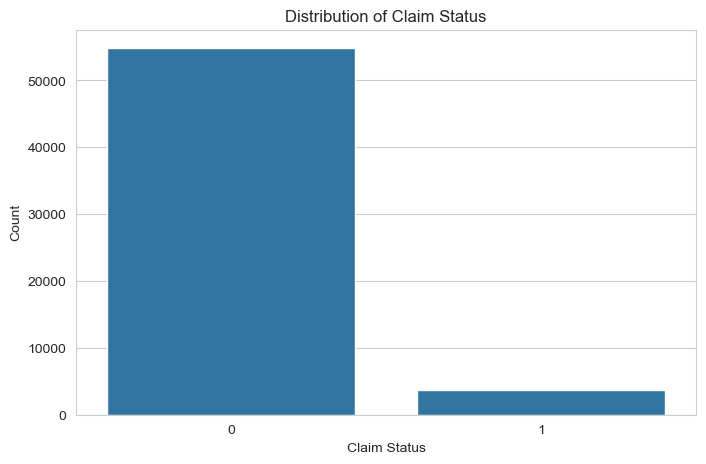

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x='claim_status',data=data)
plt.title('Distribution of Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Count')
plt.show()

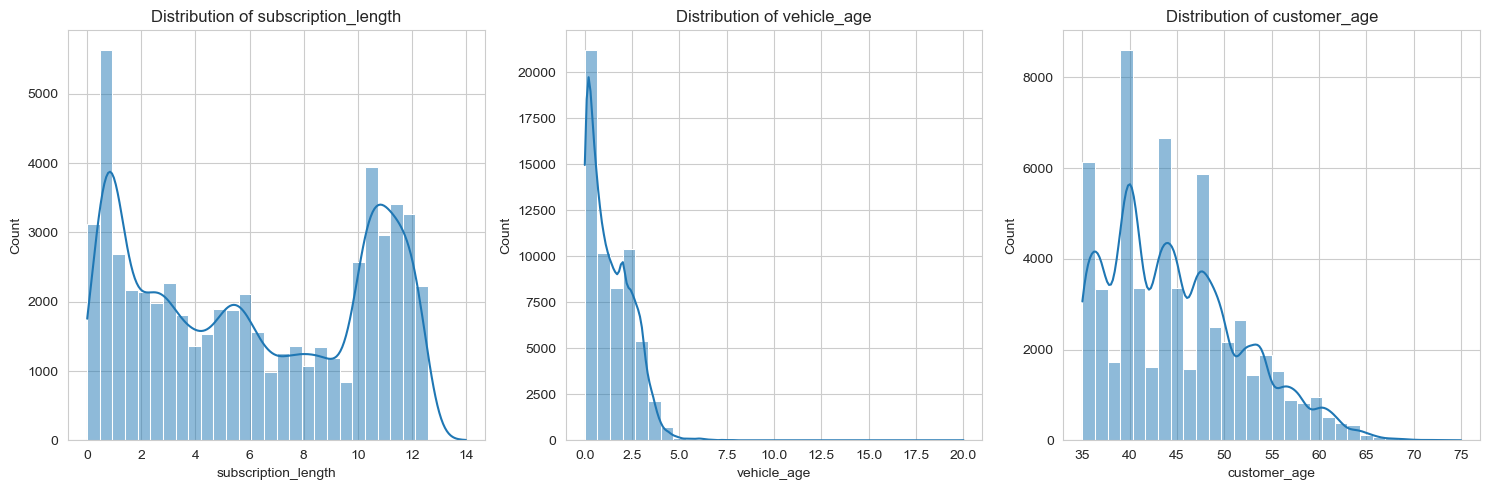

In [21]:
numerical_columns = ['subscription_length','vehicle_age','customer_age']
plt.figure(figsize=(15,5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1,3,i)
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

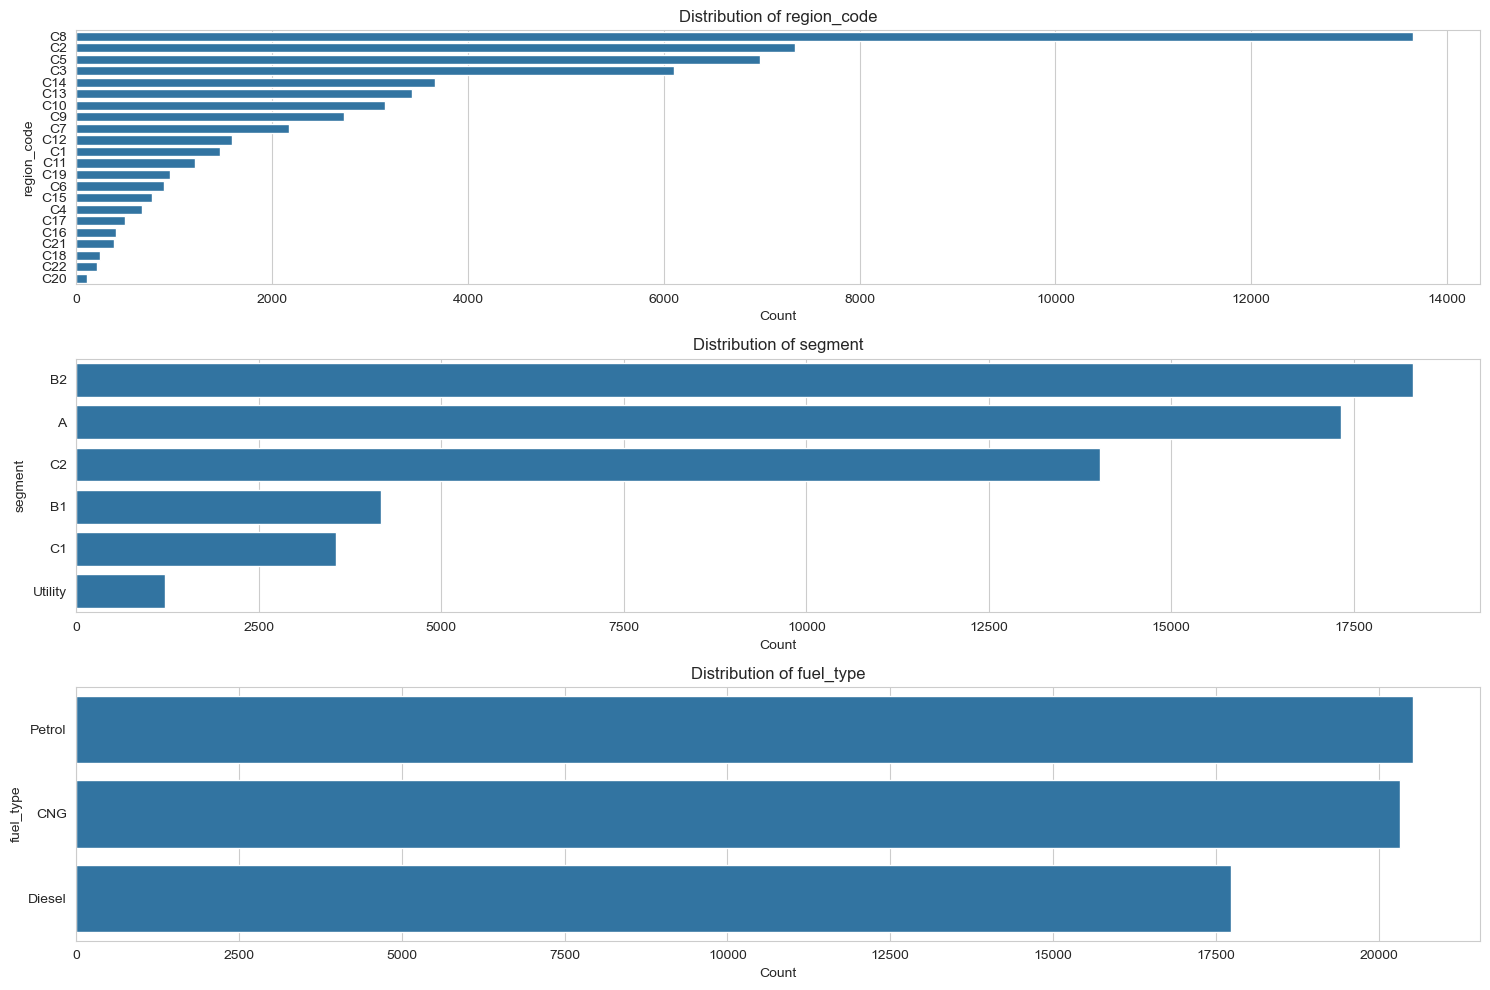

In [25]:
categorical_columns  = ['region_code','segment','fuel_type']
plt.figure(figsize=(15,10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3,1,i)
    sns.countplot(y=column,data=data, order = data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.utils import resample
majority = data[data.claim_status == 0]
minority = data[data.claim_status == 1]
minority_oversampled = resample(minority, replace=True, n_samples=len(majority),random_state=42)
# combine majority class with oversampled minority class
oversampled_data = pd.concat([majority, minority_oversampled])

# check the distribution of undersampled and oversampled datasets
oversampled_distribution = oversampled_data.claim_status.value_counts()

oversampled_distribution

claim_status
0    54844
1    54844
Name: count, dtype: int64

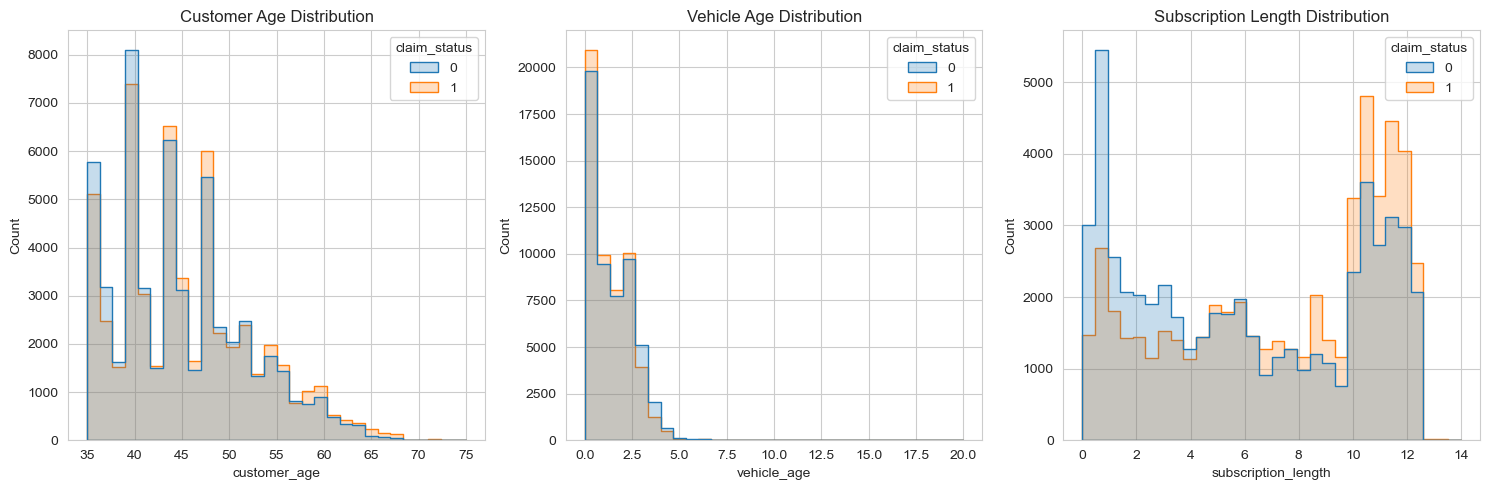

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.histplot(data=oversampled_data, x='customer_age',hue='claim_status', element='step', bins=30)
plt.title('Customer Age Distribution')

# 'vehicle_age' distribution
plt.subplot(1, 3, 2)
sns.histplot(data=oversampled_data, x='vehicle_age', hue='claim_status', element='step', bins=30)
plt.title('Vehicle Age Distribution')

# 'subscription_length' distribution
plt.subplot(1, 3, 3)
sns.histplot(data=oversampled_data, x='subscription_length', hue='claim_status', element='step', bins=30)
plt.title('Subscription Length Distribution')

plt.tight_layout()
plt.show()

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# encode categorical variables
le = LabelEncoder()
encoded_data = data.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

# separate features and target variable
X = encoded_data.drop('claim_status', axis=1)
y = encoded_data['claim_status']

# create a random forest classifier model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# get feature importance
feature_importance = rf_model.feature_importances_

# create a dataframe for visualization of feature importance
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df.head(10))  # displaying the top 10 important features

                Feature  Importance
0             policy_id    0.321072
1   subscription_length    0.248309
3          customer_age    0.176639
2           vehicle_age    0.135190
5        region_density    0.053838
4           region_code    0.052649
7                 model    0.000957
24               length    0.000846
26         gross_weight    0.000834
11          engine_type    0.000791


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# drop 'Policy_id' column from the data
oversampled_data = oversampled_data.drop('policy_id', axis=1)

# prepare the oversampled data
X_oversampled = oversampled_data.drop('claim_status', axis=1)
y_oversampled = oversampled_data['claim_status']

# encoding categorical columns
X_oversampled_encoded = X_oversampled.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_oversampled_encoded, y_oversampled, test_size=0.3, random_state=42)

# create and train the Random Forest model
rf_model_oversampled = RandomForestClassifier(random_state=42)
rf_model_oversampled.fit(X_train, y_train)

# predictions
y_pred = rf_model_oversampled.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     16574
           1       0.96      1.00      0.98     16333

    accuracy                           0.98     32907
   macro avg       0.98      0.98      0.98     32907
weighted avg       0.98      0.98      0.98     32907



In [35]:
original_encoded = data.drop('policy_id', axis=1).copy()
encoders = {col: LabelEncoder().fit(X_oversampled[col]) for col in X_oversampled.select_dtypes(include=['object']).columns}

for col in original_encoded.select_dtypes(include=['object']).columns:
    if col in encoders:
        original_encoded[col] = encoders[col].transform(original_encoded[col])

original_encoded_predictions = rf_model_oversampled.predict(original_encoded.drop('claim_status', axis=1))

comparison_df = pd.DataFrame({
    'Actual': original_encoded['claim_status'],
    'Predicted': original_encoded_predictions
})

print(comparison_df.head(10))

   Actual  Predicted
0       0          0
1       0          0
2       0          0
3       0          1
4       0          0
5       0          0
6       0          0
7       0          0
8       0          0
9       0          0


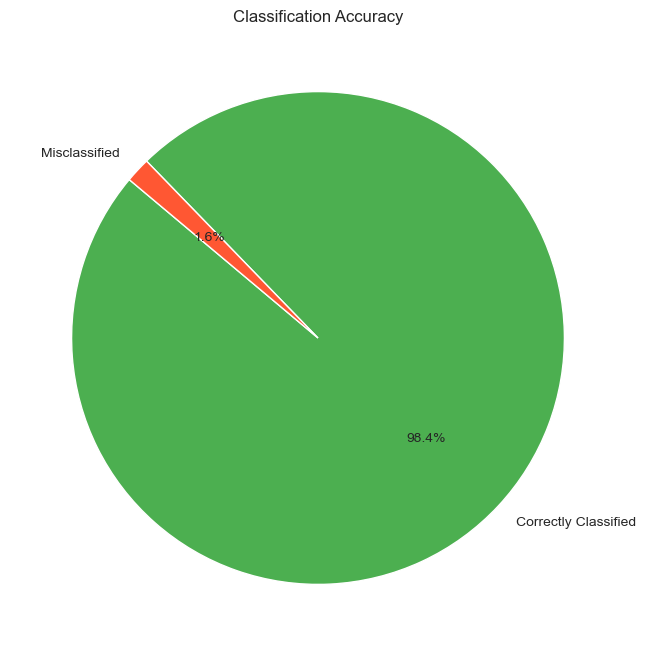

In [37]:
correctly_classified = (comparison_df['Actual'] == comparison_df['Predicted']).sum()
incorrectly_classified = (comparison_df['Actual'] != comparison_df['Predicted']).sum()

classification_counts = [correctly_classified, incorrectly_classified]
labels = ['Correctly Classified', 'Misclassified']

# create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(classification_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FF5733'])
plt.title('Classification Accuracy')
plt.show()